# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at forecasting using the data scraper.

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [0]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#!os.chdir('task-geo')
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

--2020-04-28 20:45:58--  https://coronadatascraper.com/timeseries.csv
Resolving coronadatascraper.com (coronadatascraper.com)... 185.199.108.153, 185.199.110.153, 185.199.111.153
Connecting to coronadatascraper.com (coronadatascraper.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36751130 (35M) [text/csv]
Saving to: ‘coronavirus_timeseries.csv’

coronavirus_timeser 100%[===================>]  35.05M  52.9MB/s    in 0.7s    

2020-04-28 20:46:00 (52.9 MB/s) - ‘coronavirus_timeseries.csv’ saved [36751130/36751130]

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 460kB 45.0MB/s 
     |████████████████████████████████| 112kB 49.2MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp

In [0]:
df = pd.read_csv("coronavirus_timeseries.csv")
df['month'] = pd.to_datetime(df['date']).map(lambda x: x.month)
df['weekday'] = pd.to_datetime(df['date']).map(lambda x: x.weekday())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2015


We will now construct a list of suitable data at the county level.

In [0]:
def loop_through_geo_codes(df):
  df_county_list = []
  for code in df['county'].unique():
    mask = df['county'] == code
    df_code = df[mask]
    ts_count = len(df_code)
    if ts_count > 60:
      df_county_list.append(df_code)
  return df_county_list 
county_info = loop_through_geo_codes(df)
print(len(county_info))

343


## Forecasting in Antwerp
We will now piece together some simple tutorial code for forecasting new cases in Antwerp.

In [0]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df['new_cases'] = antwerp_df.cases.diff()
print(len(antwerp_df))

97


## Data Augmentation
We will now explore using the tsaug library for forecasting.

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
config_default = {"epochs":30, "validation_split":0.1, 
          "loss":"mean_squared_error", "optimizer":'adam', 
          "geo_segment":"antwerp", "seq_len":7, "train_steps":70, 
          "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
          "beta":0.899, "additional_features":["weekday","month"]}
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'new_cases']][1:config_default["train_steps"]]
x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
y_train_full = x_train_full
r_test = RobustScaler()
test_orig = antwerp_df[['deaths', 'new_cases']][70:]
test = pd.DataFrame(r_test.fit_transform(test_orig))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [0]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.0015, 0.002, 0.003, 0.004, 0.01]
        },
        "seq_len":{
            "values":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="covid-forecast")

Create sweep with ID: ogrx4cvd
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/ogrx4cvd


In [0]:
import matplotlib.pyplot as plt
def train():
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  X_train, Y_train = create_dataset(x_train_full, y_train_full, config["seq_len"])
  X_test, y_test = create_dataset(test, test, config["seq_len"])
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, r)
  evaluate_plot_multi(model, test, config, X_test, r_test)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_df, config, x_test, scaler, predictor="new_cases"):
  arr = predict_multi(model, len(test)-config["seq_len"], x_test[0, :, :], config)
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.log({"test":plt})
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.Image(plt, caption="Plot")
  large_mse = tf.keras.losses.MSE(
    scaler.inverse_transform(arr.squeeze(0))[:, 1], test_orig[predictor][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse

def predict_multi(model, time_steps, start_rows, config):
  start_rows=np.expand_dims(start_rows, axis=0)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]


In [0]:
wandb.agent(sweep_id, function=train)


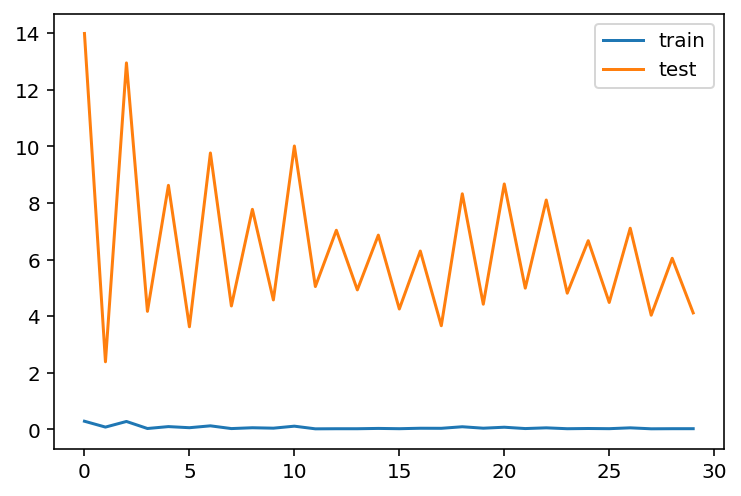

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Forecasting on all county levels
Now that we have loooked at Antwerp specifically we will design a general function to work on all geographic counties.

In [0]:
# TODO figure out how to get this into a function. Horrible to use global vars 
#like this. Still waiting on Slack response though.
#def run_geo_sweeps(county_info):
# refactor
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
def run_geo_sweeps(county_info):
  for county in county_info:
    county = county.fillna(0)
    county_name = county['county'].values[0]
    config_default = {"epochs":30, "validation_split":0.1, 
            "loss":"mean_squared_error", "optimizer":'adam', 
            "geo_segment":county_name, "seq_len":7, "train_steps":60, 
            "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
            "beta":0.899, "additional_features":["none"]}
    county['new_cases'] = county.cases.diff()
    r = RobustScaler()
    x_train_full = county[['deaths', 'new_cases']][1:config_default["train_steps"]]
    x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
    y_train_full = x_train_full
    r_test = RobustScaler()
    test_orig = county[['deaths', 'new_cases']][60:]
    test = pd.DataFrame(r_test.fit_transform(test_orig))
    sweep_id = wandb.sweep(sweep_config, project="covid-forecast")
    wandb.agent(sweep_id, function=train)


### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

### PyTorch models
Use flow-forecast library 


In [0]:
from google.colab import auth
from datetime import datetime
auth.authenticate_user()
!gcloud source repos clone github_aistream-peelout_flow-forecast --project=gmap-997

$ git clone https://github.com/AIStream-Peelout/flow-forecast
Cloning into '/content/github_aistream-peelout_flow-forecast'...
remote: Total 3614 (delta 2384), reused 3614 (delta 2384)
Receiving objects: 100% (3614/3614), 2.61 MiB | 7.04 MiB/s, done.
Resolving deltas: 100% (2384/2384), done.
Project [gmap-997] repository [github_aistream-peelout_flow-forecast] was cloned to [/content/github_aistream-peelout_flow-forecast].


To take a quick anonymous survey, run:
  $ gcloud survey



In [0]:
import os
os.chdir('/content/github_aistream-peelout_flow-forecast')
!git checkout -t origin/branch_fixes
!python setup.py develop
!pip install -r requirements.txt
!mkdir data

In [0]:
def make_config_file(wandb_config, file_path, df_len):
  train_number = df_len * .7
  validation_number = df_len *.9
  {                 
    "model_name": "MultiAttnHeadSimple",
    "model_type": "PyTorch",
    "model_params": {
      "number_time_series":3,
      "seq_len":5
     },
    "dataset_params":
    {  "class": "default",
       "training_path": file_path,
       "validation_path": file_path,
       "test_path": file_path,
       "batch_size":4,
       "forecast_history":5,
       "forecast_length":5,
       "train_end": train_number,
       "valid_start":train_number+1,
       "valid_end": validation_number,
       "target_col": ["new_cases"],
       "relevant_cols": ["new_cases", "month", "weekday"],
       "scaler": "StandardScaler", 
       "interpolate": False
    },
    "training_params":
    {
       "criterion":"MSE",
       "optimizer": "Adam",
       "optim_params":
       {

       },
       "lr": 0.001,
       "epochs": 4,
       "batch_size":4
    
    },
    "GCS": False,
    
    "wandb": {
       "name": "flood_forecast_circleci",
       "tags": ["dummy_run", "circleci"],
       "project": "repo-flood_forecast"
    },
    "forward_params":{},
   "metrics":["MSE"],
   "inference_params":
   {     
         "datetime_start":"2016-05-31",
          "hours_to_forecast":336, 
          "test_csv_path":"tests/test_data/keag_small.csv",
          "dataset_params":{
             "file_path": "tests/test_data/keag_small.csv",
             "forecast_history":5,
             "forecast_length":5,
             "relevant_cols": ["new_cases", "month", "weekday"],
             "target_col": ["new_cases"],
             "scaling": "StandardScaler",
             "interpolate_param": False
          }
   }
       
   
}
    